In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

DATA_DIR = Path("../../01_data") / "predictive_model"
CORPUS_PATH = DATA_DIR / "df_auto_corpus_area_tech.parquet"




In [2]:
df = pd.read_parquet(CORPUS_PATH)

# Sadece paper + patent
df = df[df["source_type"].isin(["paper", "patent"])].copy()

# year ve month NA olanları at
df = df.dropna(subset=["year", "month"])

# Güvenli int çevirme
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)

# Date oluştur
df["date"] = pd.to_datetime(
    dict(year=df["year"], month=df["month"], day=1)
)

df.head()


,year,month,text,source_type,auto_focus_area,auto_tech_cluster,date
0,2023,12,Internet of Things Enabled Machine Learning-Ba...,paper,Manufacturing_Industrial_AI,Production_AI,2023-12-01
1,2018,11,Connected and Autonomous Driving. The articles...,paper,Communication_Technologies,Telematics,2018-11-01
2,2024,10,Designing Enterprise Internet of Things System...,paper,Communication_Technologies,Mobility_Platforms,2024-10-01
3,2021,3,Deep Learning Feature Extraction for Brain Tum...,paper,Manufacturing_Industrial_AI,Defect_Detection,2021-03-01
4,2023,2,Revolutionizing EV Sustainability: Machine Lea...,paper,Powertrain_Energy_Battery,SOH_Estimation,2023-02-01


In [3]:
g = df.groupby(
    ["auto_focus_area", "auto_tech_cluster", "date", "source_type"]
).size().reset_index(name="n")

pivot = g.pivot_table(
    index=["auto_focus_area", "auto_tech_cluster", "date"],
    columns="source_type",
    values="n",
    fill_value=0
).reset_index()

pivot.columns.name = None

for col in ["paper", "patent"]:
    if col not in pivot.columns:
        pivot[col] = 0

pivot["n_total"] = pivot["paper"] + pivot["patent"]
pivot["share_paper"] = np.where(pivot["n_total"] > 0, pivot["paper"] / pivot["n_total"], 0)
pivot["share_patent"] = np.where(pivot["n_total"] > 0, pivot["patent"] / pivot["n_total"], 0)

df_ts = pivot.copy()
df_ts.head()


,auto_focus_area,auto_tech_cluster,date,paper,patent,n_total,share_paper,share_patent
0,Communication_Technologies,Fleet_AI,2016-01-01,1.0,0.0,1.0,1.0,0.0
1,Communication_Technologies,Fleet_AI,2016-05-01,0.0,1.0,1.0,0.0,1.0
2,Communication_Technologies,Fleet_AI,2016-06-01,0.0,1.0,1.0,0.0,1.0
3,Communication_Technologies,Fleet_AI,2017-01-01,0.0,1.0,1.0,0.0,1.0
4,Communication_Technologies,Fleet_AI,2017-06-01,1.0,0.0,1.0,1.0,0.0


In [4]:
def prepare_time_series(group_df: pd.DataFrame, value_col: str):
    g = group_df.sort_values("date")
    g = g[["date", value_col]].dropna()

    if len(g) < 4:
        return None, None

    t = np.arange(len(g)).reshape(-1, 1)
    y = g[value_col].values.astype(float)
    return t, y

In [5]:
def linear_forecast(group_df: pd.DataFrame, value_col: str, horizon: int = 12):
    g = group_df.sort_values("date")
    t, y = prepare_time_series(g, value_col)
    if t is None:
        return g, None

    model = LinearRegression()
    model.fit(t, y)

    last_t = t[-1, 0]
    future_t = np.arange(last_t + 1, last_t + 1 + horizon).reshape(-1, 1)
    y_pred = model.predict(future_t)

    last_date = g["date"].max()
    future_dates = pd.date_range(
        start=last_date + pd.offsets.MonthBegin(1),
        periods=horizon,
        freq="MS"
    )

    forecast_df = pd.DataFrame({
        "date": future_dates,
        f"forecast_{value_col}": y_pred
    })

    return g, forecast_df


In [6]:
# === Cell: logistic (S-curve) forecast ===
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def _logistic_fn(t, K, r, t0):
    """
    K : üst sınır (carrying capacity)
    r : büyüme hızı
    t0: inflection point
    """
    return K / (1.0 + np.exp(-r * (t - t0)))


def logistic_forecast(group_df: pd.DataFrame,
                      value_col: str,
                      horizon: int = 12):
    """
    value_col: 'n_total' ya da 'share_patent' gibi metrikler için
    S-curve (lojistik) fit + forecast üretir.

    Hazırdaki prepare_time_series ve linear_forecast fonksiyonlarını kullanır.
    Fit başarısız olursa otomatik linear forecast'e düşer.
    """
    g = group_df.sort_values("date")
    t, y = prepare_time_series(g, value_col)
    if t is None:
        return g, None

    t = t.astype(float).ravel()

    # y'yi 0–1 aralığına normalize et (fit için stabil)
    y_min, y_max = float(y.min()), float(y.max())
    if y_max == y_min:
        # tamamen düz seri → lineere düş
        return linear_forecast(g, value_col, horizon=horizon)

    y_norm = (y - y_min) / (y_max - y_min)

    # ilk tahminler
    p0 = [
        1.0,                # K ~ 1
        0.3,                # r (büyüme hızı)
        np.median(t)        # t0 (inflection point)
    ]

    try:
        params, _ = curve_fit(
            _logistic_fn,
            t,
            y_norm,
            p0=p0,
            maxfev=10000
        )
        K, r, t0 = params

        last_t = t[-1]
        future_t = np.arange(last_t + 1, last_t + 1 + horizon)

        # geçmiş + gelecek için tahmin
        t_all = np.concatenate([t, future_t])
        y_pred_norm_all = _logistic_fn(t_all, K, r, t0)
        y_pred_norm_all = np.clip(y_pred_norm_all, 0.0, 1.0)

        # tekrar orijinal skala
        y_pred_all = y_min + y_pred_norm_all * (y_max - y_min)
        y_future = y_pred_all[len(t):]

        last_date = g["date"].max()
        future_dates = pd.date_range(
            start=last_date + pd.offsets.MonthBegin(1),
            periods=horizon,
            freq="MS"
        )

        forecast_df = pd.DataFrame({
            "date": future_dates,
            f"logistic_{value_col}": y_future
        })

        return g, forecast_df

    except Exception:
        # Fit patlarsa sessizce linear'a düş
        return linear_forecast(g, value_col, horizon=horizon)


In [7]:
span = 6  # 6 aylık yumuşatma

actual["n_total_ewma"] = actual["n_total"].ewm(span=span, adjust=False).mean()

plt.figure(figsize=(8, 4))

# Ham veri (sivri)
plt.plot(actual["date"], actual["n_total"], alpha=0.3, label="actual volume (raw)")

# Yumuşatılmış veri
plt.plot(actual["date"], actual["n_total_ewma"], linewidth=2, label="actual volume (EWMA)")

if forecast is not None:
    plt.plot(
        forecast["date"],
        forecast["forecast_n_total"],
        linestyle="--",
        label="forecast volume"
    )

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'actual' is not defined

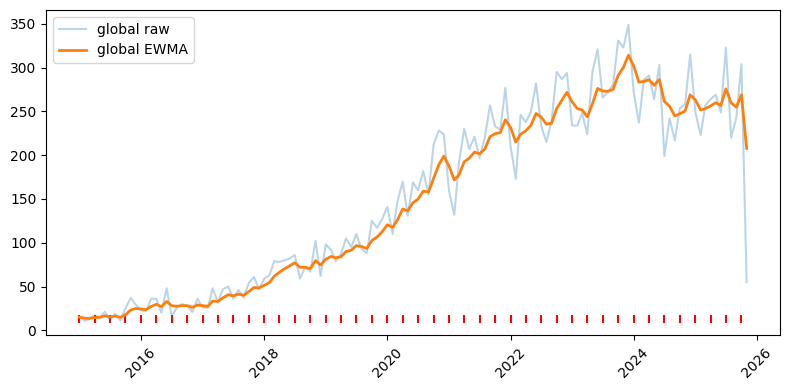

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(df_global["date"], df_global["n_total"], alpha=0.3, label="global raw")
plt.plot(df_global["date"], df_global["n_total_ewma"], linewidth=2, label="global EWMA")

# === Quarter points ===
quarters = df_global[df_global["date"].dt.month.isin([1,4,7,10])]
plt.scatter(
    quarters["date"],
    [df_global["n_total_ewma"].min() * 0.95] * len(quarters),  # En altta
    color="red",
    s=30,
    marker="|"
)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



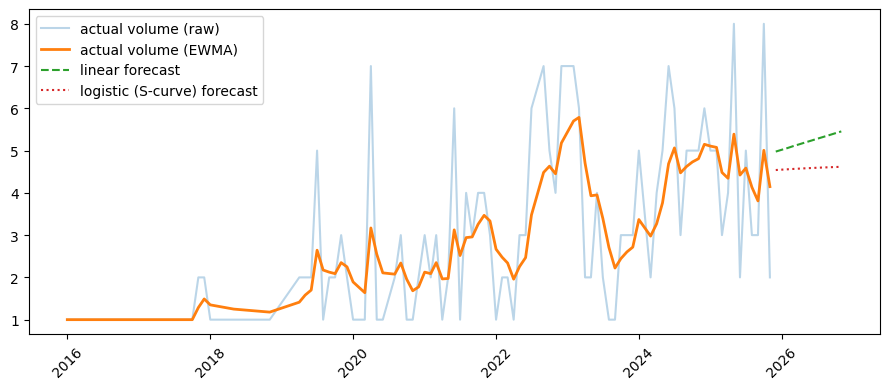

In [8]:
# === Cell: örnek teknoloji için 4 eğriyi çiz ===
sample = df_ts.iloc[0]
tmp = df_ts[
    (df_ts["auto_focus_area"] == sample["auto_focus_area"]) &
    (df_ts["auto_tech_cluster"] == sample["auto_tech_cluster"])
].copy()

actual_lin, forecast_lin = linear_forecast(tmp, "n_total", horizon=12)
actual_log, forecast_log = logistic_forecast(tmp, "n_total", horizon=12)

# EWMA
span = 6
actual_lin = actual_lin.sort_values("date")
actual_lin["n_total_ewma"] = actual_lin["n_total"].ewm(span=span, adjust=False).mean()

plt.figure(figsize=(9, 4))

# Ham seri
plt.plot(actual_lin["date"], actual_lin["n_total"],
         alpha=0.3, label="actual volume (raw)")

# EWMA
plt.plot(actual_lin["date"], actual_lin["n_total_ewma"],
         linewidth=2, label="actual volume (EWMA)")

# Lineer forecast
if forecast_lin is not None:
    plt.plot(forecast_lin["date"], forecast_lin["forecast_n_total"],
             linestyle="--", label="linear forecast")

# Lojistik forecast
if forecast_log is not None and f"logistic_n_total" in forecast_log.columns:
    plt.plot(forecast_log["date"], forecast_log["logistic_n_total"],
             linestyle=":", label="logistic (S-curve) forecast")

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
def estimate_growth(df_ts: pd.DataFrame):
    rows = []

    for (area, tech), g in df_ts.groupby(["auto_focus_area", "auto_tech_cluster"]):
        t, y = prepare_time_series(g, "n_total")
        if t is None:
            continue

        model = LinearRegression()
        model.fit(t, y)
        slope = float(model.coef_[0])

        rows.append({
            "auto_focus_area": area,
            "auto_tech_cluster": tech,
            "growth_slope_n_total": slope,
            "n_total_last": y[-1]
        })

    return pd.DataFrame(rows)

df_growth = estimate_growth(df_ts)
df_growth.sort_values("growth_slope_n_total", ascending=False).head(20)


,auto_focus_area,auto_tech_cluster,growth_slope_n_total,n_total_last
14,Manufacturing_Industrial_AI,Production_AI,0.414713,4.0
13,Manufacturing_Industrial_AI,Defect_Detection,0.252761,5.0
20,Powertrain_Energy_Battery,SOH_Estimation,0.194535,5.0
16,Powertrain_Energy_Battery,Fast_Charging,0.160272,1.0
28,Sensing_Perception_VehicleUnderstanding,Camera_2D,0.150833,4.0
30,Sensing_Perception_VehicleUnderstanding,Environment_Modeling,0.150320,1.0
3,Communication_Technologies,Telematics,0.101243,4.0
22,Powertrain_Energy_Battery,Thermal_Management,0.087415,9.0
5,Communication_Technologies,V2X,0.087353,3.0
36,Sensing_Perception_VehicleUnderstanding,Trajectory_Prediction,0.082819,2.0


In [10]:
def forecast_paper_to_patent_shift(df_ts: pd.DataFrame,
                                   horizon: int = 12,
                                   min_app: float = 0.7,
                                   max_research: float = 0.3,
                                   growth_thr: float = 0.03,
                                   decline_thr: float = -0.03) -> pd.DataFrame:
    """
    min_app      : 'application' sayılacak minimum patent payı
    max_research : 'research' sayılacak maksimum patent payı
    growth_thr   : anlamlı artış eşiği (future_mean - last_val)
    decline_thr  : anlamlı düşüş eşiği
    """

    def classify_stage(last_share_patent: float,
                       future_mean: float) -> str:
        delta = future_mean - last_share_patent

        # 1) Over-Mature: zaten patent-heavy ve patent payı düşüyor
        if last_share_patent >= min_app and delta <= decline_thr:
            return "Over-Mature"

        # 2) Application Now: patent-heavy ve en azından stabil / artıyor
        if last_share_patent >= min_app:
            return "Application Now"

        # 3) Still Research: patent payı düşük ve belirgin artış yok
        if last_share_patent <= max_research and delta <= growth_thr:
            return "Still Research"

        # 4) Transitioning: geri kalan her şey
        return "Transitioning"

    rows = []

    for (area, tech), g in df_ts.groupby(["auto_focus_area", "auto_tech_cluster"]):
        actual, forecast = linear_forecast(g, "share_patent", horizon=horizon)
        if forecast is None:
            continue

        last_val = actual["share_patent"].iloc[-1]
        future_mean = forecast["forecast_share_patent"].mean()
        stage = classify_stage(last_val, future_mean)

        rows.append({
            "auto_focus_area": area,
            "auto_tech_cluster": tech,
            "last_share_patent": last_val,
            "forecast_share_patent_mean": future_mean,
            "delta_share_patent": future_mean - last_val,
            "tech_stage": stage
        })

    return pd.DataFrame(rows)


# Çalıştır
df_transition = forecast_paper_to_patent_shift(df_ts, horizon=12)
df_transition.sort_values("tech_stage").head(40)



,auto_focus_area,auto_tech_cluster,last_share_patent,forecast_share_patent_mean,delta_share_patent,tech_stage
1,Communication_Technologies,Mobility_Platforms,0.800000,0.821010,2.100988e-02,Application Now
3,Communication_Technologies,Telematics,0.750000,0.772013,2.201278e-02,Application Now
26,Robotic_Factory_Autonomous_Delivery,Vehicle_OS,0.909091,0.924711,1.561987e-02,Application Now
11,Cybersecurity_Safety_Governance,Secure_Update,1.000000,1.000000,2.220446e-16,Application Now
0,Communication_Technologies,Fleet_AI,1.000000,0.705216,-2.947844e-01,Over-Mature
34,Sensing_Perception_VehicleUnderstanding,SLAM,1.000000,0.741884,-2.581161e-01,Over-Mature
33,Sensing_Perception_VehicleUnderstanding,Radar_FF,1.000000,0.489848,-5.101524e-01,Over-Mature
32,Sensing_Perception_VehicleUnderstanding,Occupancy_Grid,1.000000,0.348552,-6.514478e-01,Over-Mature
31,Sensing_Perception_VehicleUnderstanding,Lidar_Detection,1.000000,0.729607,-2.703926e-01,Over-Mature
30,Sensing_Perception_VehicleUnderstanding,Environment_Modeling,1.000000,0.616095,-3.839050e-01,Over-Mature


In [ ]:
df_ts.to_parquet(DATA_DIR / "area_tech_timeseries.parquet", index=False)
df_growth.to_parquet(DATA_DIR / "forecast_area_tech_growth.parquet", index=False)
df_transition.to_parquet(DATA_DIR / "forecast_area_tech_transition.parquet", index=False)

print("Saved:")
print(DATA_DIR / "area_tech_timeseries.parquet")
print(DATA_DIR / "forecast_area_tech_growth.parquet")
print(DATA_DIR / "forecast_area_tech_transition.parquet")


Saved:
..\..\01_data\predictive_model\area_tech_timeseries.parquet
..\..\01_data\predictive_model\forecast_area_tech_growth.parquet
..\..\01_data\predictive_model\forecast_area_tech_transition.parquet


In [ ]:
from predictive_components.analytics import (
    load_area_tech_ts,
    get_fastest_growing_topics,
    get_transitioning_technologies,
    get_likely_to_mature_next_year,
)


In [2]:
df_ts = load_area_tech_ts()
df_ts.head()


,auto_focus_area,auto_tech_cluster,date,paper,patent,n_total,share_paper,share_patent
0,Communication_Technologies,Fleet_AI,2016-01-01,1.0,0.0,1.0,1.0,0.0
1,Communication_Technologies,Fleet_AI,2016-05-01,0.0,1.0,1.0,0.0,1.0
2,Communication_Technologies,Fleet_AI,2016-06-01,0.0,1.0,1.0,0.0,1.0
3,Communication_Technologies,Fleet_AI,2017-01-01,0.0,1.0,1.0,0.0,1.0
4,Communication_Technologies,Fleet_AI,2017-06-01,1.0,0.0,1.0,1.0,0.0


In [3]:
df_fast = get_fastest_growing_topics(df_ts, top_n=20)
df_fast


,auto_focus_area,auto_tech_cluster,growth_slope_n_total,n_total_last
14,Manufacturing_Industrial_AI,Production_AI,0.414713,4.0
13,Manufacturing_Industrial_AI,Defect_Detection,0.252761,5.0
20,Powertrain_Energy_Battery,SOH_Estimation,0.194535,5.0
16,Powertrain_Energy_Battery,Fast_Charging,0.160272,1.0
28,Sensing_Perception_VehicleUnderstanding,Camera_2D,0.150833,4.0
30,Sensing_Perception_VehicleUnderstanding,Environment_Modeling,0.150320,1.0
3,Communication_Technologies,Telematics,0.101243,4.0
22,Powertrain_Energy_Battery,Thermal_Management,0.087415,9.0
5,Communication_Technologies,V2X,0.087353,3.0
36,Sensing_Perception_VehicleUnderstanding,Trajectory_Prediction,0.082819,2.0


In [4]:
df_transition = get_transitioning_technologies(df_ts, horizon=12)
df_transition


,auto_focus_area,auto_tech_cluster,last_share_patent,forecast_share_patent_mean,delta_share_patent,tech_stage
0,Communication_Technologies,Fleet_AI,1.000000,0.705216,-2.947844e-01,Over-Mature
1,Communication_Technologies,Mobility_Platforms,0.800000,0.821010,2.100988e-02,Application Now
2,Communication_Technologies,Ride_Sharing,0.000000,0.184649,1.846495e-01,Transitioning
3,Communication_Technologies,Telematics,0.750000,0.772013,2.201278e-02,Application Now
4,Communication_Technologies,Traffic_Coordination,1.000000,0.637292,-3.627077e-01,Over-Mature
5,Communication_Technologies,V2X,1.000000,0.944734,-5.526616e-02,Over-Mature
6,Cybersecurity_Safety_Governance,IDS,1.000000,0.361437,-6.385627e-01,Over-Mature
7,Cybersecurity_Safety_Governance,ISO26262,0.000000,0.000000,0.000000e+00,Still Research
8,Cybersecurity_Safety_Governance,PKI,0.000000,0.288858,2.888579e-01,Transitioning
9,Cybersecurity_Safety_Governance,Privacy_AI,0.000000,0.161090,1.610902e-01,Transitioning


In [5]:
df_mature_next = get_likely_to_mature_next_year(df_ts, horizon=12)
df_mature_next


,auto_focus_area,auto_tech_cluster,last_share_patent,forecast_share_patent_mean,delta_share_patent,tech_stage
1,Communication_Technologies,Mobility_Platforms,0.80,0.821010,0.021010,Application Now
3,Communication_Technologies,Telematics,0.75,0.772013,0.022013,Application Now
35,Sensing_Perception_VehicleUnderstanding,Sensor_Fusion,0.60,0.510302,-0.089698,Transitioning
36,Sensing_Perception_VehicleUnderstanding,Trajectory_Prediction,0.00,0.473680,0.473680,Transitioning
